<a href="https://colab.research.google.com/github/manrodri/tensorflow_training/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part 1: Feature Extraction

Transfer learning levareges an exiting working model architecture. Benefits:
- Proven to work on a similar problem
- We can adapt an exisint model to our input data.

In [40]:
# Are we running a GPU?
!nvidia-smi

Sun Mar  5 11:45:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
# Import dependencies
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import zipfile
import os
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

## Download and becoming one with  data 

We are using 10% of the dataset used in the multiclass classification problem, we'll scale up once we have positive results.

`DATA_URL = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'`

In [30]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-03-05 11:35:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   123MB/s    in 1.3s    

2023-03-05 11:35:17 (123 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [31]:
# Unzip the downloaded file
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [32]:
import os

for root, dirs, files in os.walk('/content/10_food_classes_10_percent'):
    print(f"directory {root} has {len(dirs)} directories and {len(files)} images")



directory /content/10_food_classes_10_percent has 2 directories and 0 images
directory /content/10_food_classes_10_percent/test has 10 directories and 0 images
directory /content/10_food_classes_10_percent/test/grilled_salmon has 0 directories and 250 images
directory /content/10_food_classes_10_percent/test/sushi has 0 directories and 250 images
directory /content/10_food_classes_10_percent/test/pizza has 0 directories and 250 images
directory /content/10_food_classes_10_percent/test/steak has 0 directories and 250 images
directory /content/10_food_classes_10_percent/test/fried_rice has 0 directories and 250 images
directory /content/10_food_classes_10_percent/test/chicken_curry has 0 directories and 250 images
directory /content/10_food_classes_10_percent/test/ice_cream has 0 directories and 250 images
directory /content/10_food_classes_10_percent/test/hamburger has 0 directories and 250 images
directory /content/10_food_classes_10_percent/test/chicken_wings has 0 directories and 250

We have the same number of test images but only 10% of the train dataset (used on 03-... notebook). Therefore we can use the same function to visualize our images.


### Visualize images

In [33]:
# let's visualize our images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + "/" + target_class
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # read image and plot it
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img



In [34]:
# Setup the train and test directories
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'


In [35]:
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # create a list of class_names from the subfolder
class_names


array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

Image shape: (512, 512, 3)


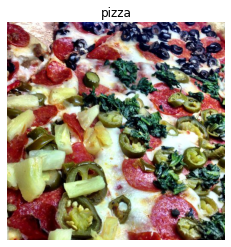

In [36]:
# Visualize images
import random
random_class = random.choice(class_names)
img = view_random_image(train_dir, random_class)

### Create data loaders

We'll use the `ImageDataGenerator` from Tensorflow.keras.image to load our images (as we did in notebook 3) into batches size 32 (it's good for your [health](https://twitter.com/ylecun/status/989610208497360896?lang=en))

In [37]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is **callbacks**.

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). 

Its main functionality is saving a model's training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq='epoch'` parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

> 🔑 **Note:** We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).



### Create TensorBoard callback


In [38]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  if dir_name[-1] == '/':
    dir_name = dir_name.strip('/')
  if experiment_name[-1] == '/':
    experiment_name = experiment_name.strip('/')
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_callback

## Creating models using TensoflowHub


In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

In fact, we're going to use two models from TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.

You might be wondering, how do you find these models on TensorFlow Hub?

Here are the steps I took:

1. Go to [tfhub.dev](https://tfhub.dev/).
2. Choose your problem domain, e.g. "Image" (we're using food images).
3. Select your TF version, which in our case is TF2.
4. Remove all "Problem domanin" filters except for the problem you're working on. 
  * **Note:** "Image feature vector" can be used alongside almost any problem, we'll get to this soon.
5. The models listed are all models which could potentially be used for your problem.

> 🤔 **Question:** *I see many options for image classification models, how do I know which is best?*

You can see a list of state of the art models on [paperswithcode.com](https://www.paperswithcode.com), a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

Since we're working with images, our target are the [models which perform best on ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet).

You'll probably find not all of the model architectures listed on paperswithcode appear on TensorFlow Hub. And this is okay, we can still use what's available.

To find our models, let's narrow down our search using the Architecture tab.

6. Select the Architecture tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear. 
  * The rule of thumb here is generally, names with larger numbers means better performing models. For example, EfficientNetB4 performs better than EfficientNetB0.
    * However, the tradeoff with larger numbers can mean they take longer to compute. 
7. Select EfficientNetB0 and you should see [something like the following](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=efficientnet-b0&tf-version=tf2):
![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-tensorflow-hub-efficientnetb0.png)
8. Clicking the one titled "[efficientnet/b0/feature-vector](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)" brings us to a page with a button that says "Copy URL". That URL is what we can use to harness the power of EfficientNetB0.
  * Copying the URL should give you something like this: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

> 🤔 **Question:** *I thought we were doing image classification, why do we choose feature vector and not classification?*

Great observation. This is where the differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.

1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes. 

  * For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class). 

    * This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with `"/classification"` in their name on TensorFlow Hub provide this kind of functionality.

2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. 

  * For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**. 

    * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem. 

    * This usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (**feature extraction**).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further **fine-tune** the pretrained model.

> 🤔 **Question:** *Why train only the top 2-3 layers in feature extraction?*

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)
*The different kinds of transfer learning. An original model, a feature extraction model (only top 2-3 layers change) and a fine-tuning model (many or all of original model get changed).*

Okay, enough talk, let's see this in action. Once we do, we'll explain what's happening.

First we'll import TensorFlow and TensorFlow Hub.

In [39]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4'
efficient_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'


resnet_v2/feature-vector/5
```
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m.build([None, 299, 299, 3])  # Batch input shape.
```

efficientnet/b0/feature-vector/1


```
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1")
])
m.build([None, expect_img_size, expect_img_size, 3])  # Batch input shape.
```




In [42]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential



In [47]:
def create_model(model_url, num_classes, image_size=224, rgb=3):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes.
    image_size (int): the size of the input images,
    rgb (int): number of rgb digits (3 => 256 bits)

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  feature_extractor_layer = hub.KerasLayer(model_url,
                    trainable=False,
                     name='feature-extractor-layer',
                     input_shape=(image_size, image_size)+(3,)
                     )

  model = Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation='softmax')
  ])

  return model



### Creating and testing ResNet Tensorflow model

In [49]:
resnet_model = create_model(
    resnet_url,
    num_classes=10,
    image_size=224,
    rgb=3
)

resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [50]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature-extractor-layer (Ke  (None, 1536)             54336736  
 rasLayer)                                                       
                                                                 
 dense (Dense)               (None, 10)                15370     
                                                                 
Total params: 54,352,106
Trainable params: 15,370
Non-trainable params: 54,336,736
_________________________________________________________________


In [51]:
resnet_model.fit(
    train_data_10_percent,
     epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
)

Epoch 1/5
24/24 [==============================] - 52s 1s/step - loss: 1.6885 - accuracy: 0.4400 - val_loss: 0.9746 - val_accuracy: 0.6840
Epoch 2/5
24/24 [==============================] - 23s 985ms/step - loss: 0.9066 - accuracy: 0.7133 - val_loss: 0.7563 - val_accuracy: 0.7628
Epoch 3/5
24/24 [==============================] - 22s 926ms/step - loss: 0.7239 - accuracy: 0.7867 - val_loss: 0.6668 - val_accuracy: 0.7856
Epoch 4/5
24/24 [==============================] - 22s 927ms/step - loss: 0.6448 - accuracy: 0.8027 - val_loss: 0.6308 - val_accuracy: 0.7908
Epoch 5/5
24/24 [==============================] - 20s 877ms/step - loss: 0.5602 - accuracy: 0.8213 - val_loss: 0.6164 - val_accuracy: 0.7936
